# Projet de programmation : classification

Données utilisées : music genre 
(https://www.kaggle.com/datasets/vicsuperman/prediction-of-music-genre/data)

Cette base de donnée présente 50000 titres de chansons associés à un ensemble de variables descriptives. L'objectif de cette base de donnée est de réalisée une classification supervisée sur le genre musical.

Etapes :
- Prétraitement, manipulation des données manquantes, identification des variables d'intérêt
- Test de plusieurs algorithmes
- Evaluation de performances, grit search (optimisation des hyperparamètres) + présentation de l'évaluation de performances en fonction de la valeur des hyperparamètres 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Chargement et prétraitement des données

In [2]:
# Récupération de données
filename = "music_genre.csv"
data = pd.read_csv(filename, header=0)
print(data.shape)

(50005, 18)


Observons les différentes variables présentes dans la base de donnée ainsi que leur type.

In [3]:
print(data.dtypes)

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
obtained_date        object
valence             float64
music_genre          object
dtype: object


La base de donnée présente des variables quantitatives (instance_id, popularity, acousticness, danceability, duration_ms, energy, instrumentalness, liveness, loudness, speechiness) et catégorielles (artist_name, track_name, key, mode, tempo, obtaines_date, music_genre). \
Un prétraitement des données sera donc nécessaire pour les données catégorielles.

Observons maintenant les éventuelles données manquantes de la base de données.

In [4]:
# Affichage des lignes avec des données manquantes.
print(data[data.isna().any(axis=1)])

       instance_id artist_name track_name  popularity  acousticness  \
10000          NaN         NaN        NaN         NaN           NaN   
10001          NaN         NaN        NaN         NaN           NaN   
10002          NaN         NaN        NaN         NaN           NaN   
10003          NaN         NaN        NaN         NaN           NaN   
10004          NaN         NaN        NaN         NaN           NaN   

       danceability  duration_ms  energy  instrumentalness  key  liveness  \
10000           NaN          NaN     NaN               NaN  NaN       NaN   
10001           NaN          NaN     NaN               NaN  NaN       NaN   
10002           NaN          NaN     NaN               NaN  NaN       NaN   
10003           NaN          NaN     NaN               NaN  NaN       NaN   
10004           NaN          NaN     NaN               NaN  NaN       NaN   

       loudness mode  speechiness tempo obtained_date  valence music_genre  
10000       NaN  NaN          NaN

Seules 5 lignes présentent des données manquantes. Elles sont en réalité des lignes vides. Nous pouvons donc les supprimer directement.

In [4]:
data = data.dropna()

<Axes: xlabel='popularity', ylabel='Density'>

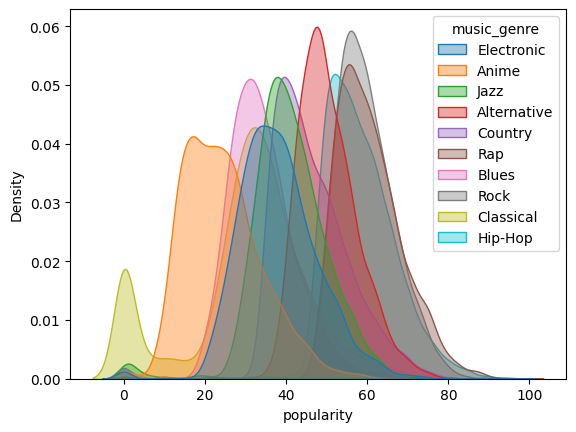

In [6]:
sns.kdeplot(data=data, x="popularity", hue="music_genre", fill=True, common_norm=False, alpha=0.4)

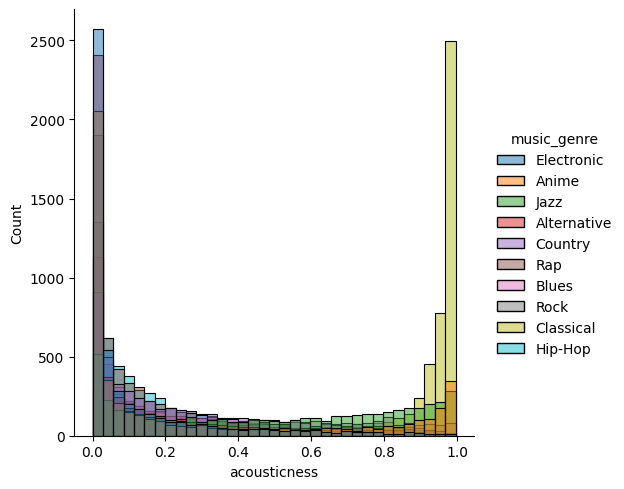

In [7]:
sns.displot(data=data, x="acousticness", hue="music_genre")

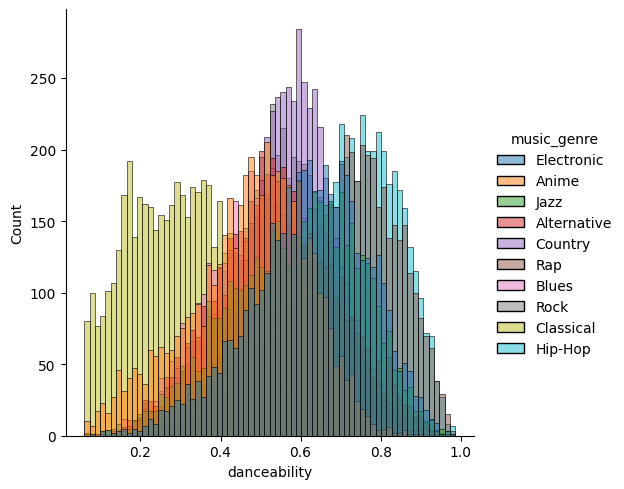

In [8]:
sns.displot(data=data, x="danceability", hue="music_genre")

(4939, 18)


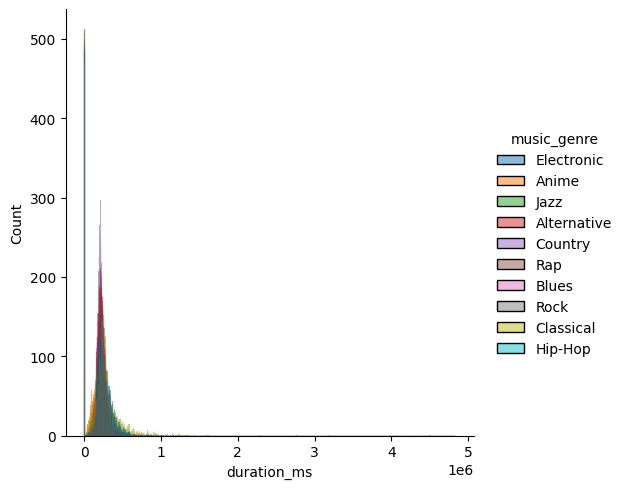

In [29]:
sns.displot(data=data, x="duration_ms", hue="music_genre")
print(data[data['duration_ms'] < 0].shape)


Un grand nombre de titres ont une durée indiquée de -1 ms. Il s'agit probablement d'une donnée manquante que nous devons alors traiter.

/tmp/ipykernel_9751/149633596.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  g.fig.show()


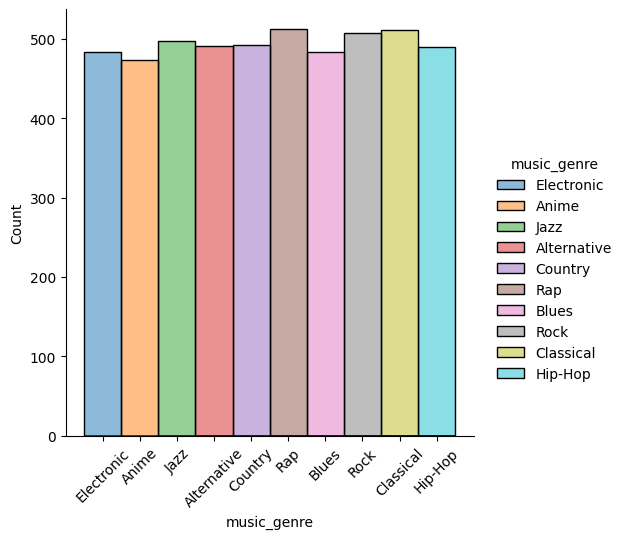

In [39]:
g = sns.displot(data=data[data['duration_ms'] < 0], x="music_genre", hue="music_genre")
g.set_xticklabels(rotation=45)
g.fig.show()

Une quantité équivalente de titres pour chaque classe est concernée. Nous allons donc choisir de supprimer ces titres de la base de donnée (concervant donc 45000 titres, soit 90 % des données).

In [5]:
data = data[data['duration_ms'] > -1]

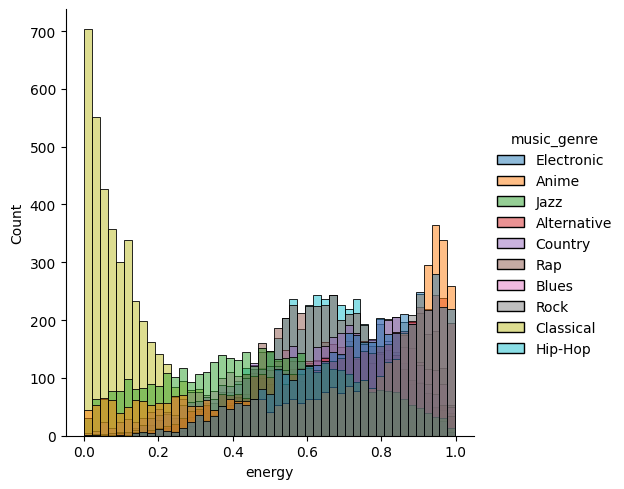

In [8]:
sns.displot(data=data, x="energy", hue="music_genre")

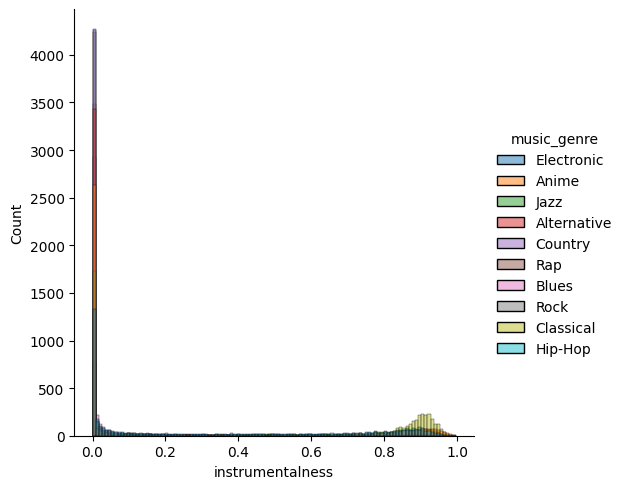

In [11]:
sns.displot(data=data, x="instrumentalness", hue="music_genre")

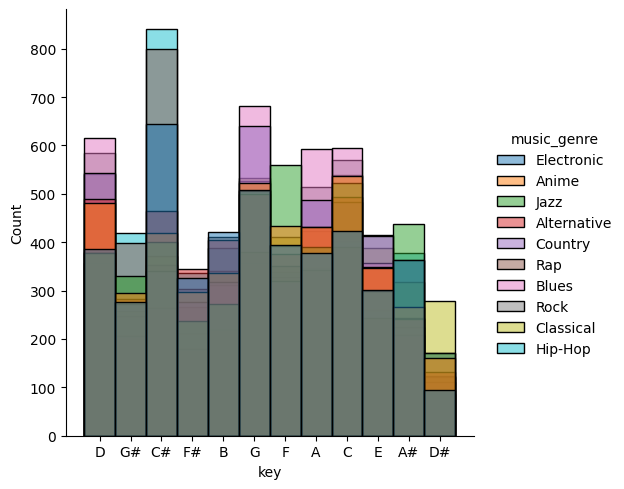

In [43]:
sns.displot(data=data, x="key", hue="music_genre")

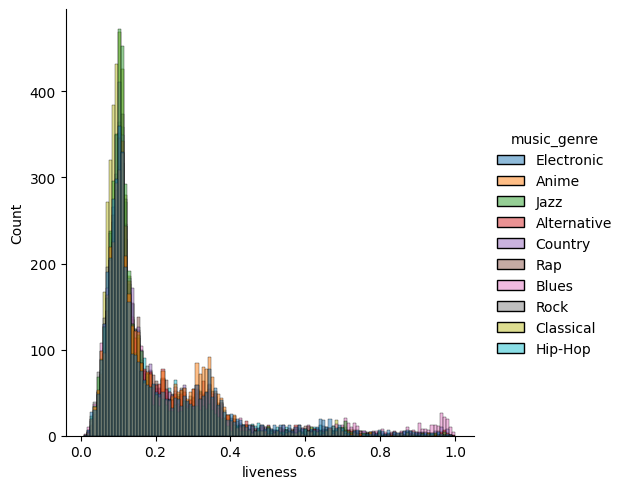

In [44]:
sns.displot(data=data, x="liveness", hue="music_genre")

In [13]:
sns.pairplot(data, hue="music_genre", kind="kde", diag_kind="hist", corner=True)

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fccd9f3fac0>
Traceback (most recent call last):
  File "/home/mverlynde/miniconda3/envs/projvguig/lib/python3.10/site-packages/matplotlib/transforms.py", line 198, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id_self: pop(k))
KeyboardInterrupt: 


<Axes: xlabel='music_genre'>

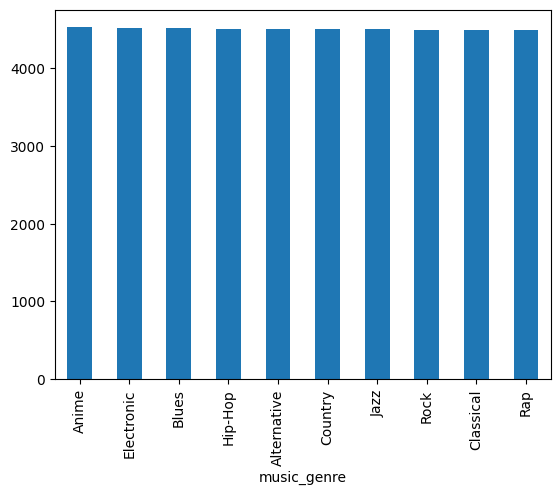

In [45]:
data['music_genre'].value_counts().plot(kind='bar')

tempo
?                     4501
120.0                   17
140.007                 17
100.00299999999999      15
130.016                 14
                      ... 
159.94299999999998       1
104.214                  1
100.583                  1
172.06099999999998       1
99.20100000000001        1
Name: count, Length: 27289, dtype: int64


<Axes: xlabel='music_genre'>

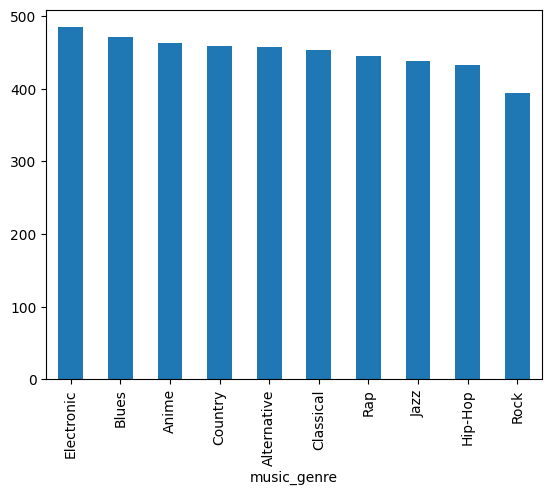

In [6]:
print(data['tempo'].value_counts())
data.loc[data['tempo']=='?']['music_genre'].value_counts().plot(kind='bar')

In [13]:
def preprocess_category(X, key_OH = True):
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder

    le_key = LabelEncoder()
    le_key.fit(X["key"])
    key_encoded = le_key.transform(X["key"]).reshape(-1,1)
    key_df = pd.DataFrame(key_encoded, columns=['key'])

    if key_OH:
        ohe_key = OneHotEncoder(sparse_output=False)
        key_encoded = ohe_key.fit_transform(key_encoded)
        key_df = pd.DataFrame(key_encoded, columns=le_key.classes_)

    le_mode = LabelEncoder()
    le_mode.fit(X["mode"])
    mode_encoded = le_mode.transform(X["mode"]).reshape(-1,1)
    mode_df = pd.DataFrame(mode_encoded, columns=['mode'])

    return(key_df, mode_df)

In [14]:
Y = data['music_genre']
X = data[['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence', 'key', 'mode']]
print(X.shape)

#plt.figure()
#plt.bar(np.arange(len(corr)), corr)

(45061, 12)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train_init, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=0)
X_test_init, X_val_init, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

le_Y = LabelEncoder()
Y_train = le_Y.fit_transform(Y_train)
Y_val = le_Y.fit_transform(Y_val)
Y_test = le_Y.fit_transform(Y_test)

print(le_Y.classes_)

['Alternative' 'Anime' 'Blues' 'Classical' 'Country' 'Electronic'
 'Hip-Hop' 'Jazz' 'Rap' 'Rock']


In [16]:
X_train_key, X_train_mode = preprocess_category(X_train_init, key_OH=True)
X_train = X_train_init.drop(["key", "mode"], axis=1)

X_train = pd.concat((X_train.reset_index(), X_train_key.reset_index()), axis=1)
X_train = pd.concat((X_train, X_train_mode), axis=1)
X_train.drop("index", axis=1, inplace=True)

X_test_key, X_test_mode = preprocess_category(X_test_init, key_OH=True)
X_test = X_test_init.drop(["key", "mode"], axis=1)

X_test = pd.concat((X_test.reset_index(), X_test_key.reset_index()), axis=1)
X_test = pd.concat((X_test, X_test_mode), axis=1)
X_test.drop("index", axis=1, inplace=True)

In [17]:
X_train

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,valence,...,C,C#,D,D#,E,F,F#,G,G#,mode
0,53.0,0.000915,0.498,227587.0,0.714,0.361000,0.1010,-7.917,0.0361,0.226,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,55.0,0.175000,0.591,240053.0,0.819,0.000000,0.0467,-6.134,0.1880,0.465,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,37.0,0.000973,0.647,217493.0,0.710,0.703000,0.0777,-4.692,0.0290,0.268,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,60.0,0.071500,0.443,438493.0,0.576,0.019300,0.4100,-8.696,0.2000,0.128,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,31.0,0.802000,0.457,474013.0,0.264,0.736000,0.0920,-13.703,0.0301,0.140,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31537,31.0,0.018400,0.244,279813.0,0.824,0.000812,0.7130,-3.630,0.0517,0.545,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
31538,63.0,0.134000,0.425,237297.0,0.554,0.000086,0.0963,-4.145,0.0298,0.288,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
31539,80.0,0.039400,0.912,179022.0,0.587,0.010000,0.1110,-7.395,0.0582,0.435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
31540,55.0,0.040500,0.843,196571.0,0.608,0.000000,0.1160,-5.289,0.0574,0.590,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [18]:
X_train.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence',
       'A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#',
       'mode'],
      dtype='object')

## 1. Mise en oeuvre des modèles

Il s'agit de programmation objet et d'héritage... Mais pour l'utilisateur, c'est surtout un ensemble de modèles facilement disponible sur l'étagère.

1. Initialisation du modèle & des paramètres (=création du classifieur)
2. Apprentissage sur les données d'entrainement (=`fit`)
3. Inférence sur les données d'apprentissage ou de test (=`predict`)<BR>
  ATTENTION: predict attend un ensemble de données, pas une seule

Précision du modèle :  34.50


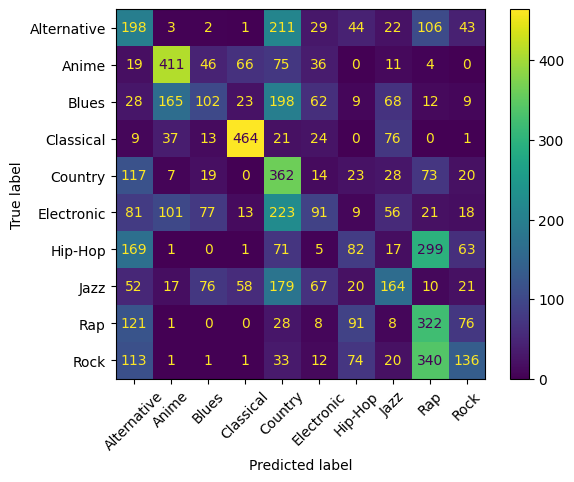

In [20]:
from sklearn import naive_bayes

# creation d'un modèle bayesien naïf
mod = naive_bayes.GaussianNB() 
# apprentissage sur les données d'apprentissage
mod.fit(X_train, Y_train)
# inférence, sur un individu (le premier point de test)
Y_pred = mod.predict(X_test) # attention, la fonction est
                                    # prévue pour traiter un ensemble de points
                                    # et pas une seule donnée
                                    # d'où les [] supplémentaires

print("Précision du modèle : ", "%.2f" % (mod.score(X_test, Y_test)*100))

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(le_Y.inverse_transform(Y_test), le_Y.inverse_transform(Y_pred), xticks_rotation = 45)


Précision du modèle :  9.54


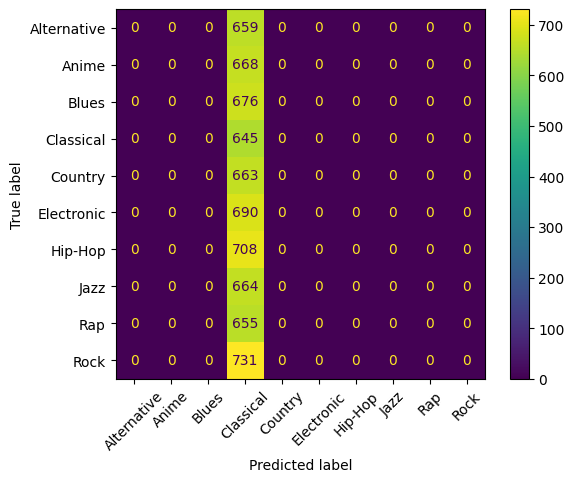

In [21]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(solver='lbfgs')
mod.fit(X_train, Y_train)

Y_pred = mod.predict(X_test)
print("Précision du modèle : ", "%.2f" % (mod.score(X_test, Y_test)*100))

ConfusionMatrixDisplay.from_predictions(le_Y.inverse_transform(Y_test), le_Y.inverse_transform(Y_pred), xticks_rotation = 45)


Précision du modèle :  15.18
F1 score du modèle :  9.78


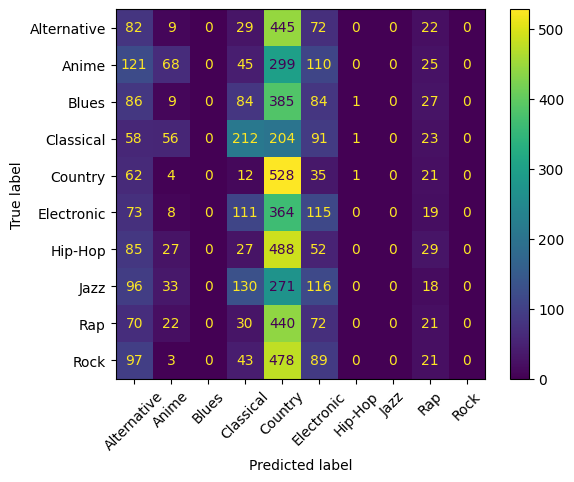

In [78]:
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score

mod = svm.SVC(decision_function_shape='ovo')
mod.fit(X_train, Y_train)
Y_pred = mod.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred, average='weighted')
print('Précision du modèle : ', "%.2f" % (accuracy*100))
print('F1 score du modèle : ', "%.2f" % (f1*100))

ConfusionMatrixDisplay.from_predictions(le_Y.inverse_transform(Y_test), le_Y.inverse_transform(Y_pred), xticks_rotation = 45)

Précision du modèle :  56.12


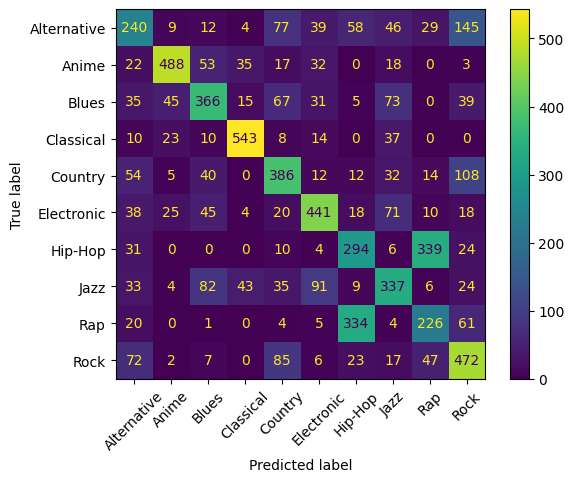

In [22]:
mod = xgb.XGBClassifier()
mod.fit(X_train,Y_train)

Y_pred = mod.predict(X_test)

print("Précision du modèle : ", "%.2f" % (mod.score(X_test, Y_test)*100))

ConfusionMatrixDisplay.from_predictions(le_Y.inverse_transform(Y_test), le_Y.inverse_transform(Y_pred), xticks_rotation = 45)

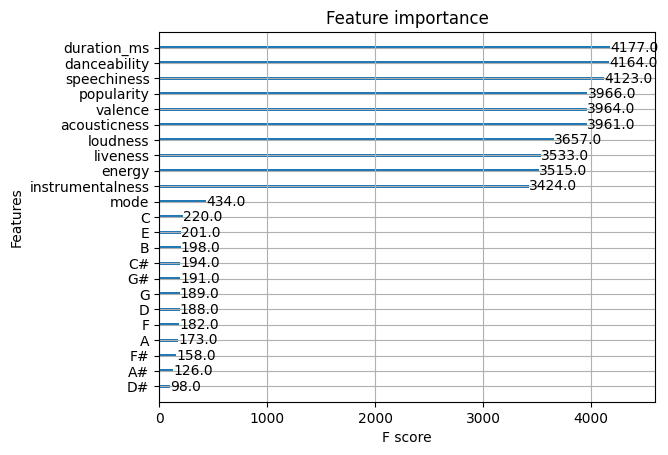

In [80]:
# Plot feature importance
xgb.plot_importance(mod)
plt.show()

0.5546678502737091


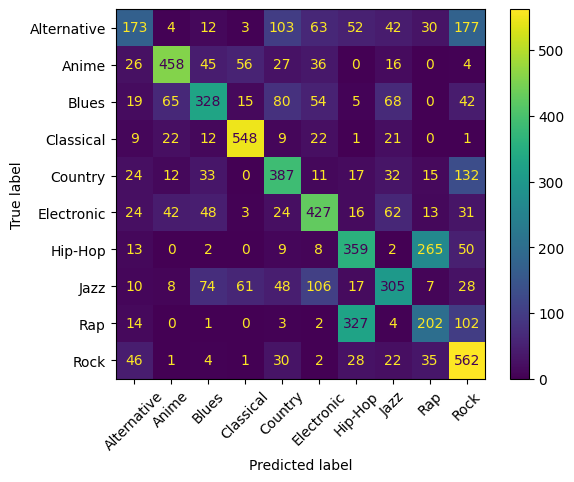

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

mod = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
mod.fit(X_train, Y_train)

Y_pred = mod.predict(X_test)
print(mod.score(X_test, Y_test))

ConfusionMatrixDisplay.from_predictions(le_Y.inverse_transform(Y_test), le_Y.inverse_transform(Y_pred), xticks_rotation = 45)

In [82]:
X_train_key, X_train_mode = preprocess_category(X_train_init, key_OH=False)
X_train = X_train_init.drop(["key", "mode"], axis=1)

X_train = pd.concat((X_train.reset_index(), X_train_key.reset_index()), axis=1)
X_train = pd.concat((X_train, X_train_mode), axis=1)
X_train.drop(["index"], axis=1, inplace=True)

X_test_key, X_test_mode = preprocess_category(X_test_init, key_OH=False)
X_test = X_test_init.drop(["key", "mode"], axis=1)

X_test = pd.concat((X_test.reset_index(), X_test_key.reset_index()), axis=1)
X_test = pd.concat((X_test, X_test_mode), axis=1)
X_test.drop(["index"], axis=1, inplace=True)


In [83]:
X_train.columns

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'valence',
       'key', 'mode'],
      dtype='object')

0.5599940819647877


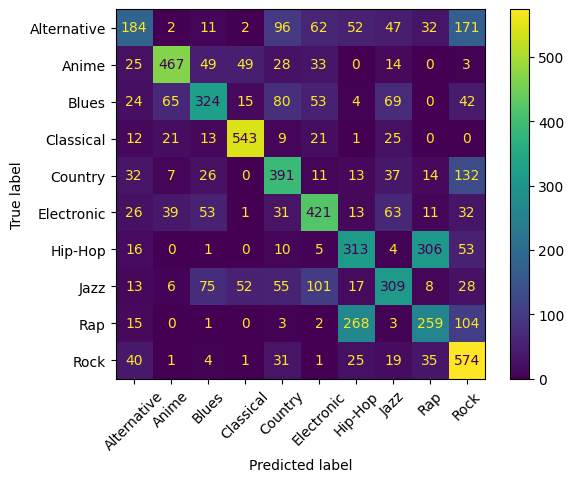

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

mod = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
mod.fit(X_train, Y_train)

Y_pred = mod.predict(X_test)
print(mod.score(X_test, Y_test))

ConfusionMatrixDisplay.from_predictions(le_Y.inverse_transform(Y_test), le_Y.inverse_transform(Y_pred), xticks_rotation = 45)

Le modèle RandomForestClassifier avec un encodage One Hot de la variable clé nous semble intéressant. Affinons les hyperparamètres.

In [85]:
X_train_key, X_train_mode = preprocess_category(X_train_init, key_OH=True)
X_train = X_train_init.drop(["key", "mode"], axis=1)

X_train = pd.concat((X_train.reset_index(), X_train_key.reset_index()), axis=1)
X_train = pd.concat((X_train, X_train_mode), axis=1)
X_train.drop(["index"], axis=1, inplace=True)

X_val_key, X_val_mode = preprocess_category(X_val_init, key_OH=True)
X_val = X_val_init.drop(["key", "mode"], axis=1)

X_val = pd.concat((X_val.reset_index(), X_val_key.reset_index()), axis=1)
X_val = pd.concat((X_val, X_val_mode), axis=1)
X_val.drop(["index"], axis=1, inplace=True)

X_test_key, X_test_mode = preprocess_category(X_test_init, key_OH=True)
X_test = X_test_init.drop(["key", "mode"], axis=1)

X_test = pd.concat((X_test.reset_index(), X_test_key.reset_index()), axis=1)
X_test = pd.concat((X_test, X_test_mode), axis=1)
X_test.drop(["index"], axis=1, inplace=True)


[0.32521717075645173, 0.46769386849280326, 0.5311330923847568, 0.5788472512840023, 0.6322363832350517, 0.7073742945913385, 0.7924037790881998, 0.8753725191807749, 0.9326295098598694, 0.9565024411895251]
[0.31908284023668637, 0.46642011834319524, 0.5196745562130177, 0.5442307692307692, 0.5644970414201184, 0.5642011834319527, 0.5661242603550296, 0.5619822485207101, 0.5557692307692308, 0.5559171597633136]


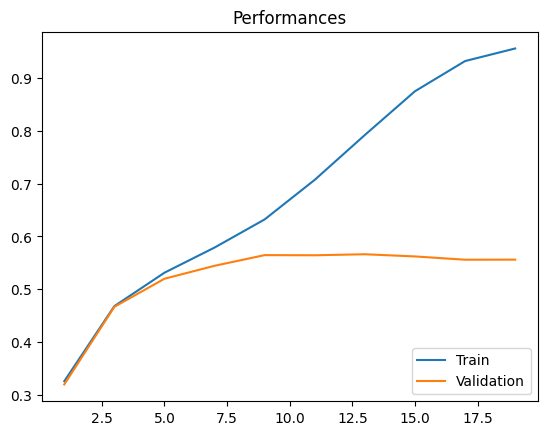

In [86]:
# proposition de classifieur qui doit mettre en évidence le phénomène
perf_train = []
perf_val  = []

for depth in range(1, 20, 2) : 
    # création du modèle
    mod = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)

    # apprentissage du modèle 
    mod.fit(X_train,Y_train)

    # évaluation
    perf_train.append(mod.score(X_train, Y_train))
    perf_val.append(mod.score(X_val, Y_val))

print(perf_train)
print(perf_val)
plt.figure()
plt.plot(range(1, 20, 2), perf_train, label='Train')
plt.plot(range(1, 20, 2), perf_val, label='Validation')
plt.title('Performances')
plt.legend(loc='lower right')

Nous observons un plateau au niveau de la courbe de performances sur le set de validation, celui-ci atteint à partir d'une profondeur d'arbre de 5 environ. Nous choisirons donc cette valeur pour le paramètre.

[0.4873819034937544, 0.6133409422357492, 0.6380064675670535, 0.6469469279056496, 0.6533510874389703, 0.6536681250396297, 0.656901908566356, 0.6601356920930822, 0.662545177858094, 0.6638450320207977, 0.664225477141589, 0.6644474034620506, 0.6663179253059412, 0.6663496290660073, 0.66593748018515, 0.6646693297825123, 0.6661277027455457, 0.665905776425084, 0.6660325914653478, 0.6660325914653478]
[0.44486354559574, 0.5254049256711781, 0.544486354559574, 0.5411581983581096, 0.5467051253605503, 0.549811404481917, 0.5511426669625028, 0.5482582649212336, 0.5500332815620147, 0.5522520523629909, 0.5529176836032837, 0.5515864211226981, 0.5529176836032837, 0.5555802085644553, 0.5546927002440648, 0.5518082982027956, 0.5553583314843576, 0.5546927002440648, 0.5522520523629909, 0.5558020856445529]


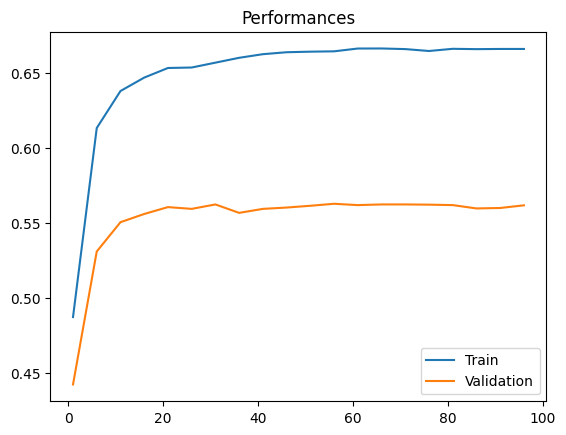

In [87]:
# proposition de classifieur qui doit mettre en évidence le phénomène
perf_train = []
perf_val  = []

for n_est in range(1, 100, 5) : 
    # création du modèle
    mod = RandomForestClassifier(n_estimators=n_est, max_depth=10, random_state=0)

    # apprentissage du modèle 
    mod.fit(X_train,Y_train)

    # évaluation
    perf_train.append(mod.score(X_train, Y_train))
    perf_val.append(mod.score(X_val, Y_val))

print(perf_train)
print(perf_test)
plt.figure()
plt.plot(range(1, 100, 5), perf_train, label='Train')
plt.plot(range(1, 100, 5), perf_val, label='Validation')
plt.title('Performances')
plt.legend(loc='lower right')

De même, nous observons un plateau au niveau de la courbe de performances sur le set de validation, celui-ci atteint à partir d'un nombre d'estimateurs de 10 environ. Nous choisirons donc cette valeur pour le paramètre.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

mod = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
mod.fit(X_train, Y_train)

Y_pred = mod.predict(X_test)
print(mod.score(X_test, Y_test))

ConfusionMatrixDisplay.from_predictions(le_Y.inverse_transform(Y_test), le_Y.inverse_transform(Y_pred), xticks_rotation = 45)